In [11]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [59]:
class Particle:

    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):

        self.dt = t[1] - t[0]
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0

        self.m = m
        self.radius = radius
        self.Id = Id


        self.p = self.m*self.v

        self.f = self.m*self.a

        # Historial

        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)

        self.F = np.zeros_like(self.R)

        self.P = np.zeros_like(self.R)

        # Fisica
        self.K = 10.

        self.VEk = np.zeros(len(t))
        
        
        # agregar energia potencial
        
        self.Ep = 0.
        self.VEp = np.zeros(len(t))
        ##
        self.L = np.zeros(len(t))
        
        
        
    def Evolution(self,i):


        self.SetPosition(i)
        self.SetVelocity(i)
        self.a = self.f/self.m + [0,-9.8]
        
        # Euler
  #      self.r += self.dt*self.v
  #      self.v += self.dt*self.a
        
        
        
        # Euler-Cromer
        self.v += self.dt*self.a
        self.r += self.dt*self.v
        

    def CalculateForce(self,p):

        d = np.linalg.norm(self.r - p.r)

        compresion = self.radius + p.radius - d

        if compresion >= 0:

            Fn = self.K * compresion**3

            self.n = (self.r - p.r)/d
            self.f = np.add(self.f,Fn*self.n)
            # Falta implementar energía potencial
            
        self.Ep += self.m*self.r[1]*9.8

    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
        self.Ep = 0.
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r

    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        if len(self.v)<=2:
            self.L[i] = np.cross(self.r,self.p)
        else:
            self.L[i] = 0
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
        
    #energia cinetica
    
    def SetPotentialEnergy(self,i):
        self.VEp[i] = self.Ep
        
        #self.A[i] = [0,-9.8]
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]

    def GetVelocity(self,scale=1):
        return self.V[::scale]

    def GetMomentum(self,scale=1):
        return self.P[::scale]

    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale]
    
    def GetPotentialEnergy(self,scale=1):
        return self.VEp[::scale]
    
    def GetAngularMomentum(self, scale=1):
        return self.L[::scale]

    # Debes agregar las paredes en este punto
    def CheckLimits(self, e=0.9):
        for i in range(2):
            if self.r[i] + self.radius > 20 and self.v[i] > 0.:
                u1 = self.v[i]  # v previa de la colisión
                self.v[i] = -self.v[i] * e  # Velocidad después de la colisión con pérdida de energía
                u2 = self.v[i]  # Velocidad después de la colisión
                self.VEk[:] -= 0.5 * self.m * (u2 ** 2 - u1 ** 2)  # Resta de energía cinética
            elif self.r[i] - self.radius < -20 and self.v[i] < 0.:
                u1 = self.v[i]  # Velocidad antes de la colisión
                self.v[i] = -self.v[i] * e  # Velocidad después de la colisión con pérdida de energía
                u2 = self.v[i]  # Velocidad despues de la colisión
                self.VEk[:] -= 0.5 * self.m * (u2 ** 2 - u1 ** 2)  # Resta de energía cinética


In [60]:
def GetParticles(N,t):

    r0 = np.array([-15.,-10.])
    v0 = np.array([2.,0])
    a0 = np.array([-9.80,-9.80])

    p0 = Particle(r0,v0,a0,t,m=1,radius=2,Id=0)
    Particles = [p0]

    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.

    return Particles

In [61]:
dt = 0.001
tmax = 30
t = np.arange(0,tmax,dt)
Particles = GetParticles(1,t)

In [62]:
def RunSimulation(t,Particles):

    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):

        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])

        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits()
            # Aca debes agregar la interaccion con la pared


    return Particles

In [63]:
Particles = RunSimulation(t,Particles)


Running simulation: 100%|█████████████████████████████████████████████████| 30000/30000 [00:02<00:00, 12655.27 Steps/s]


In [64]:
scale = 100
t1 = t[::scale]

print(Particles[0].a)

[0. 0.]


<IPython.core.display.Javascript object>


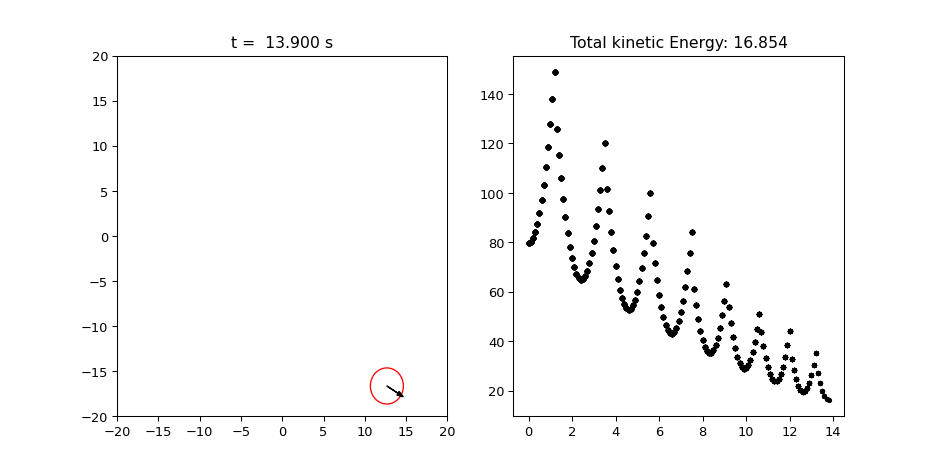

In [65]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():

    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
def Update(i):

    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))


    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy

    for p in Particles:

        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]

        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]

        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)

        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)

        KE += p.GetKineticEnergy(scale)[i]

        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')

Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)
plt.show()

#Animation.save('EsferaDura.mp4', writer=writer_)

In [66]:
#Writer = anim.writers['ffmpeg']
#writer_ = Writer(fps=10, metadata=dict(artist='Me'))
#Animation.save('EsferaDura.mp4', writer=writer_)

<IPython.core.display.Javascript object>


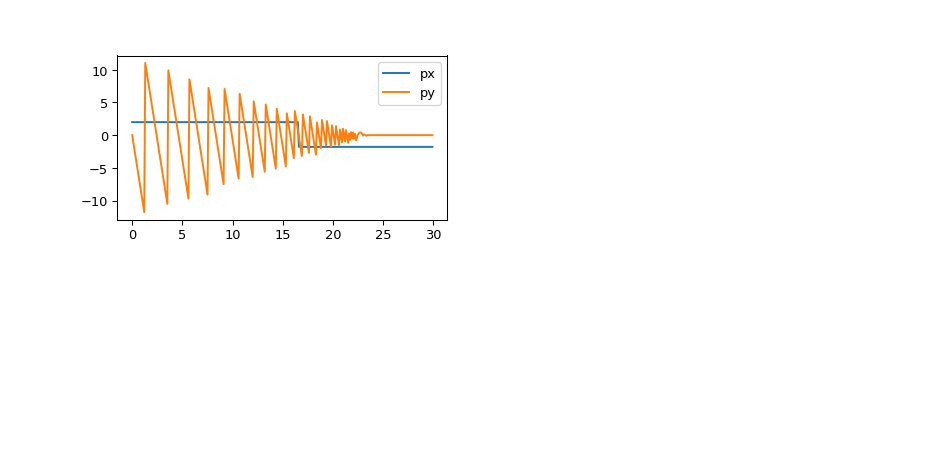

In [67]:

MomentumT = Particles[0].GetMomentum(scale)

for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))

fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(221)
ax3.plot(t1,MomentumT[:,0],label='px')
ax3.plot(t1,MomentumT[:,1],label='py')

ax3.legend()

In [68]:
MomentumT = Particles[0].GetMomentum(scale)

EnergyT = Particles[0].GetKineticEnergy(scale)

EnergyP = Particles[0].GetPotentialEnergy(scale)
MomentumL = Particles[0].GetAngularMomentum(scale)
EnergyP *= 0.5

for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))
    EnergyT = np.add(EnergyT,Particles[i].GetKineticEnergy(scale))
    EnergyP = np.add(EnergyP,Particles[i].GetPotentialEnergy(scale))
    MomentumL = np.add(MomentumL,Particles[i].GetAngularMomentum(scale))

<IPython.core.display.Javascript object>


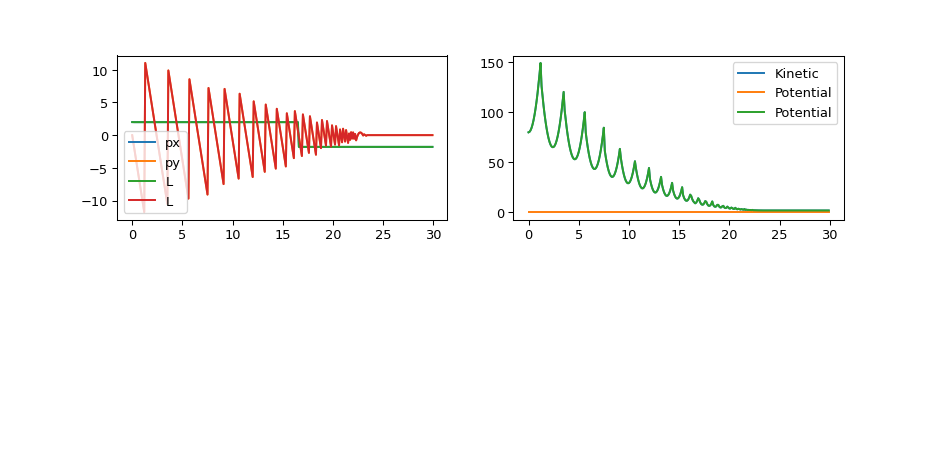

In [71]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(221)
ax4 = fig3.add_subplot(222)
ax3.plot(t1,MomentumT[:,0],label='px')
ax3.plot(t1,MomentumT[:,1],label='py')
ax4.plot(t1,EnergyT,label='Kinetic')
ax4.plot(t1,EnergyP,label='Potential')
ax4.plot(t1,EnergyT+EnergyP,label='Potential')
ax3.legend()
ax4.legend()

<IPython.core.display.Javascript object>


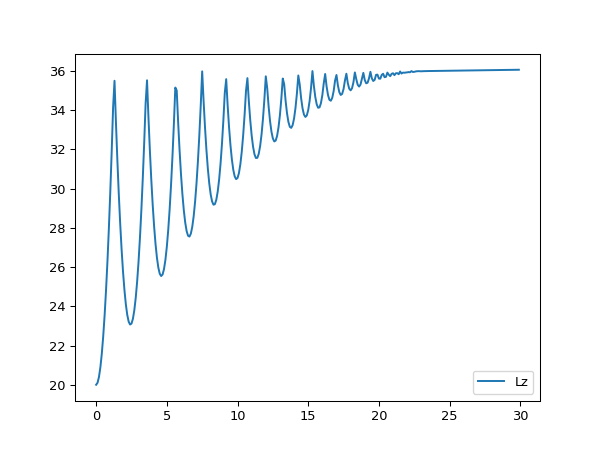

In [72]:
plt.figure()
plt.plot(t1,MomentumL,label='Lz')
plt.legend()